# Modelo Prophet

El modelo Prophet, desarrollado por Facebook (ahora Meta), es una herramienta de pronóstico de series temporales que se destaca por su facilidad de uso, capacidad de personalización y eficacia en escenarios con estacionalidad, tendencias no lineales y efectos de días festivos. Su principal ventaja radica en el manejo automático de patrones estacionales (diarios, semanales y anuales), la robustez ante datos faltantes y outliers, la posibilidad de incorporar eventos especiales y su habilidad para detectar cambios en la tendencia.

In [11]:
!pip install prophet

In [1]:
from prophet import Prophet
print("Prophet instalado correctamente")

Prophet instalado correctamente


In [5]:
!pip show prophet

Name: prophet
Version: 1.1.6
Summary: Automatic Forecasting Procedure
Home-page: https://facebook.github.io/prophet/
Author: 
Author-email: "Sean J. Taylor" <sjtz@pm.me>, Ben Letham <bletham@fb.com>
License: MIT
Location: C:\Users\natha\anaconda3\Lib\site-packages
Requires: cmdstanpy, holidays, importlib-resources, matplotlib, numpy, pandas, tqdm
Required-by: 


=== Modelo Prophet para Predicción de VIH ===

[1/6] Cargando y procesando datos...


11:52:00 - cmdstanpy - INFO - Chain [1] start processing



[2/6] Configurando modelo Prophet...

[3/6] Entrenando modelo...

[3/6] Configurando modelo Prophet...

[4/6] Entrenando modelo...


11:52:00 - cmdstanpy - INFO - Chain [1] done processing



[5/6] Realizando validación cruzada...

Resultados de validación cruzada:
     horizon    mse  rmse   mae  mape  mdape  smape  coverage
0    35 days 480.72 21.93 19.23  0.20   0.19   0.23      0.21
1    39 days 372.05 19.29 17.64  0.18   0.19   0.20      0.21
2    41 days 364.51 19.09 17.12  0.17   0.18   0.19      0.29
3    45 days 363.67 19.07 17.07  0.17   0.18   0.19      0.29
4    46 days 337.78 18.38 16.55  0.16   0.15   0.18      0.29
..       ...    ...   ...   ...   ...    ...    ...       ...
124 354 days 413.49 20.33 15.18  0.11   0.09   0.11      0.50
125 355 days 296.08 17.21 12.47  0.09   0.07   0.09      0.57
126 359 days 305.22 17.47 12.94  0.09   0.08   0.10      0.57
127 361 days 617.75 24.85 17.61  0.13   0.09   0.13      0.50
128 365 days 761.74 27.60 19.16  0.15   0.09   0.14      0.43

[129 rows x 8 columns]

[6/6] Evaluando modelo en conjunto de prueba...

[4/6] Visualizando resultados...


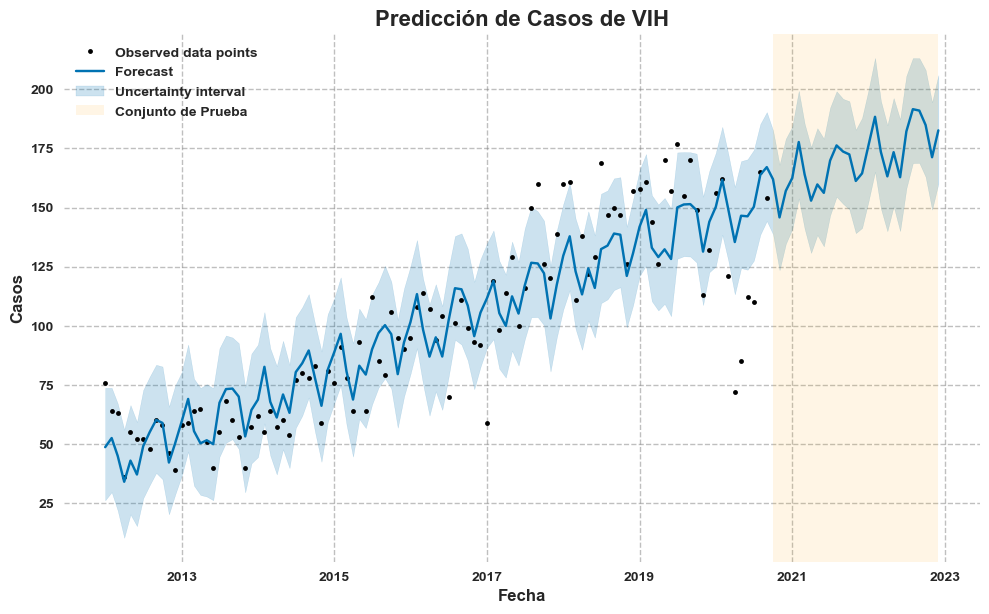

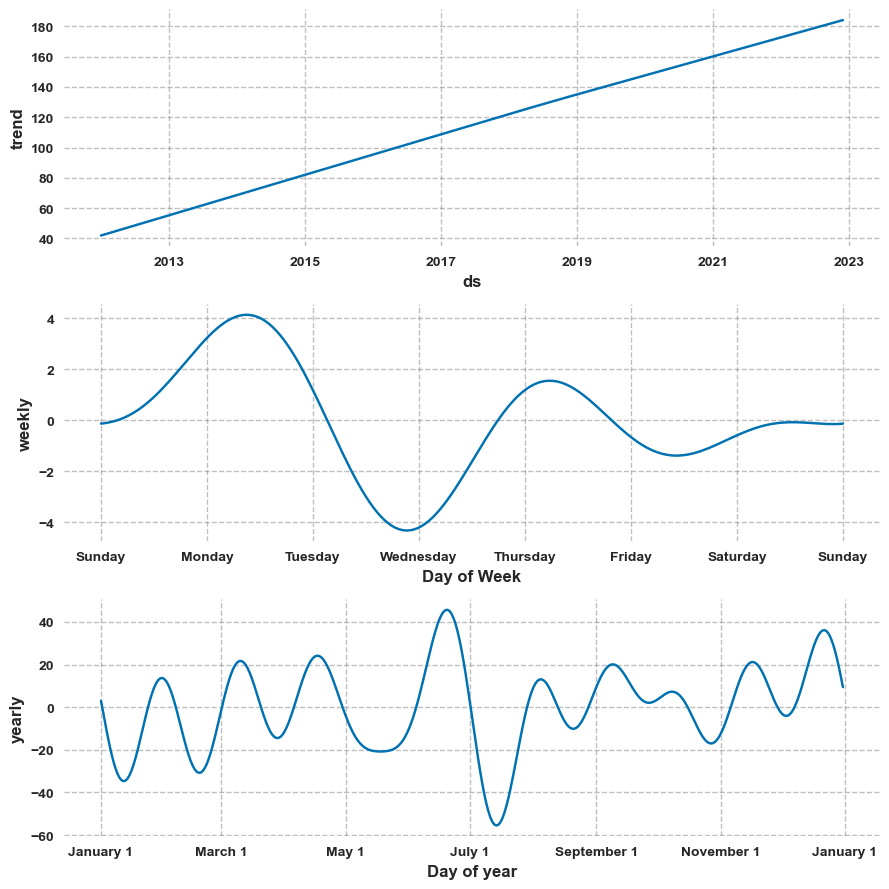

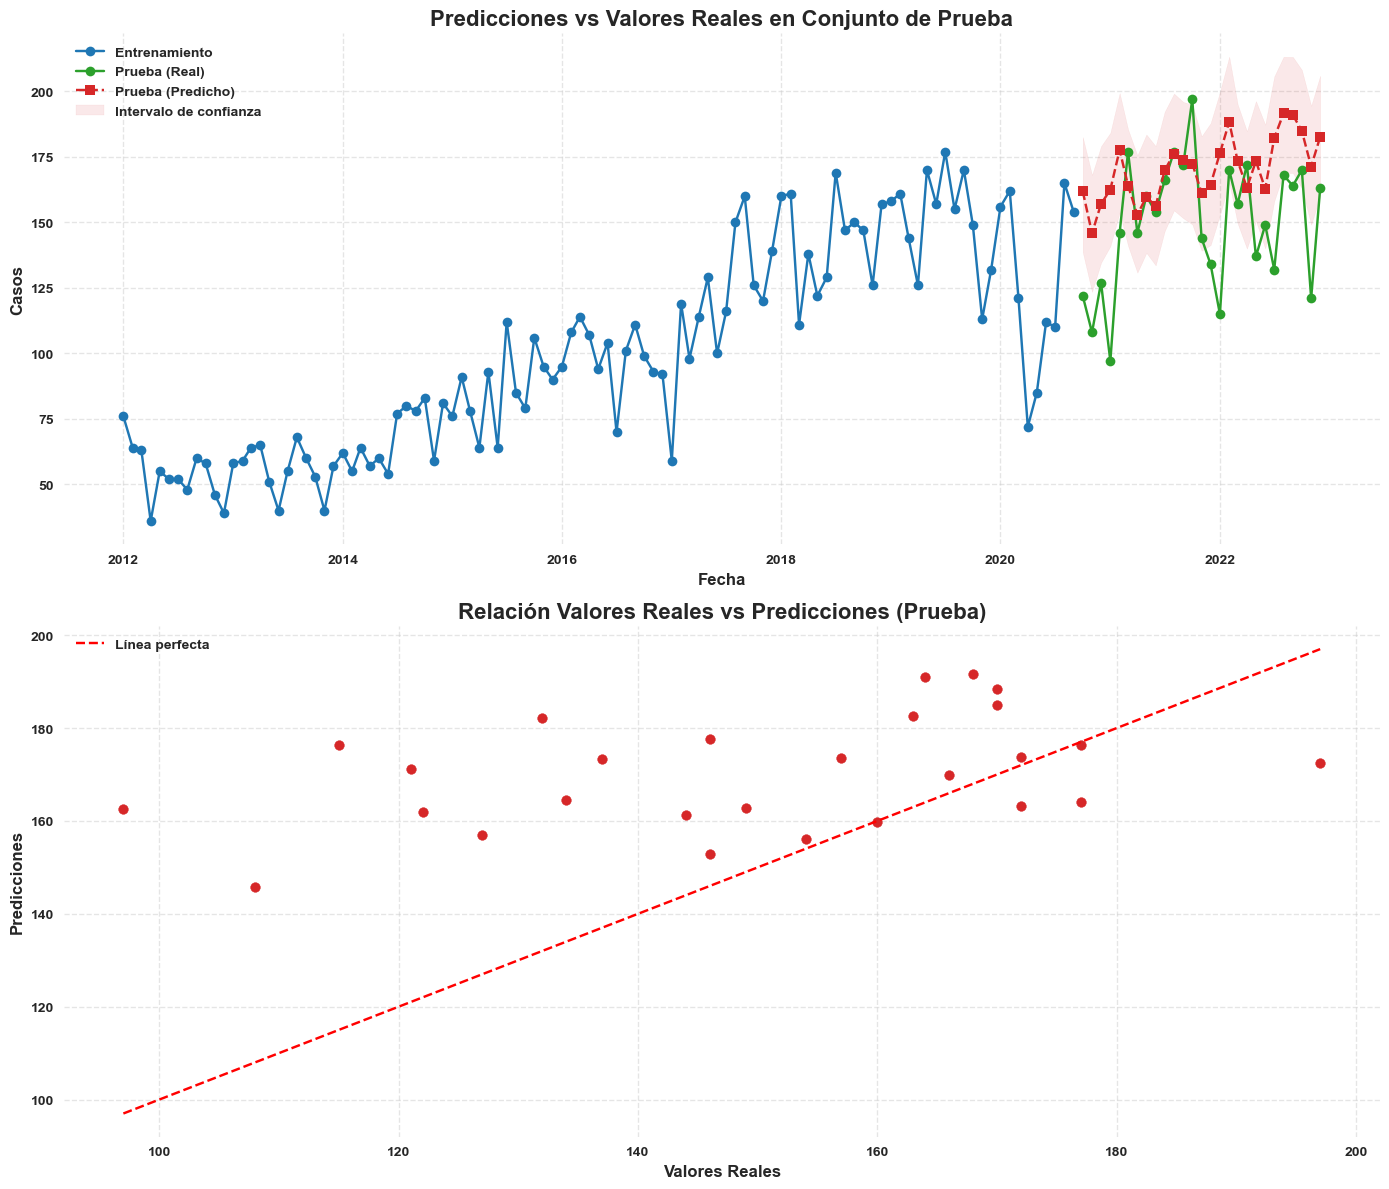

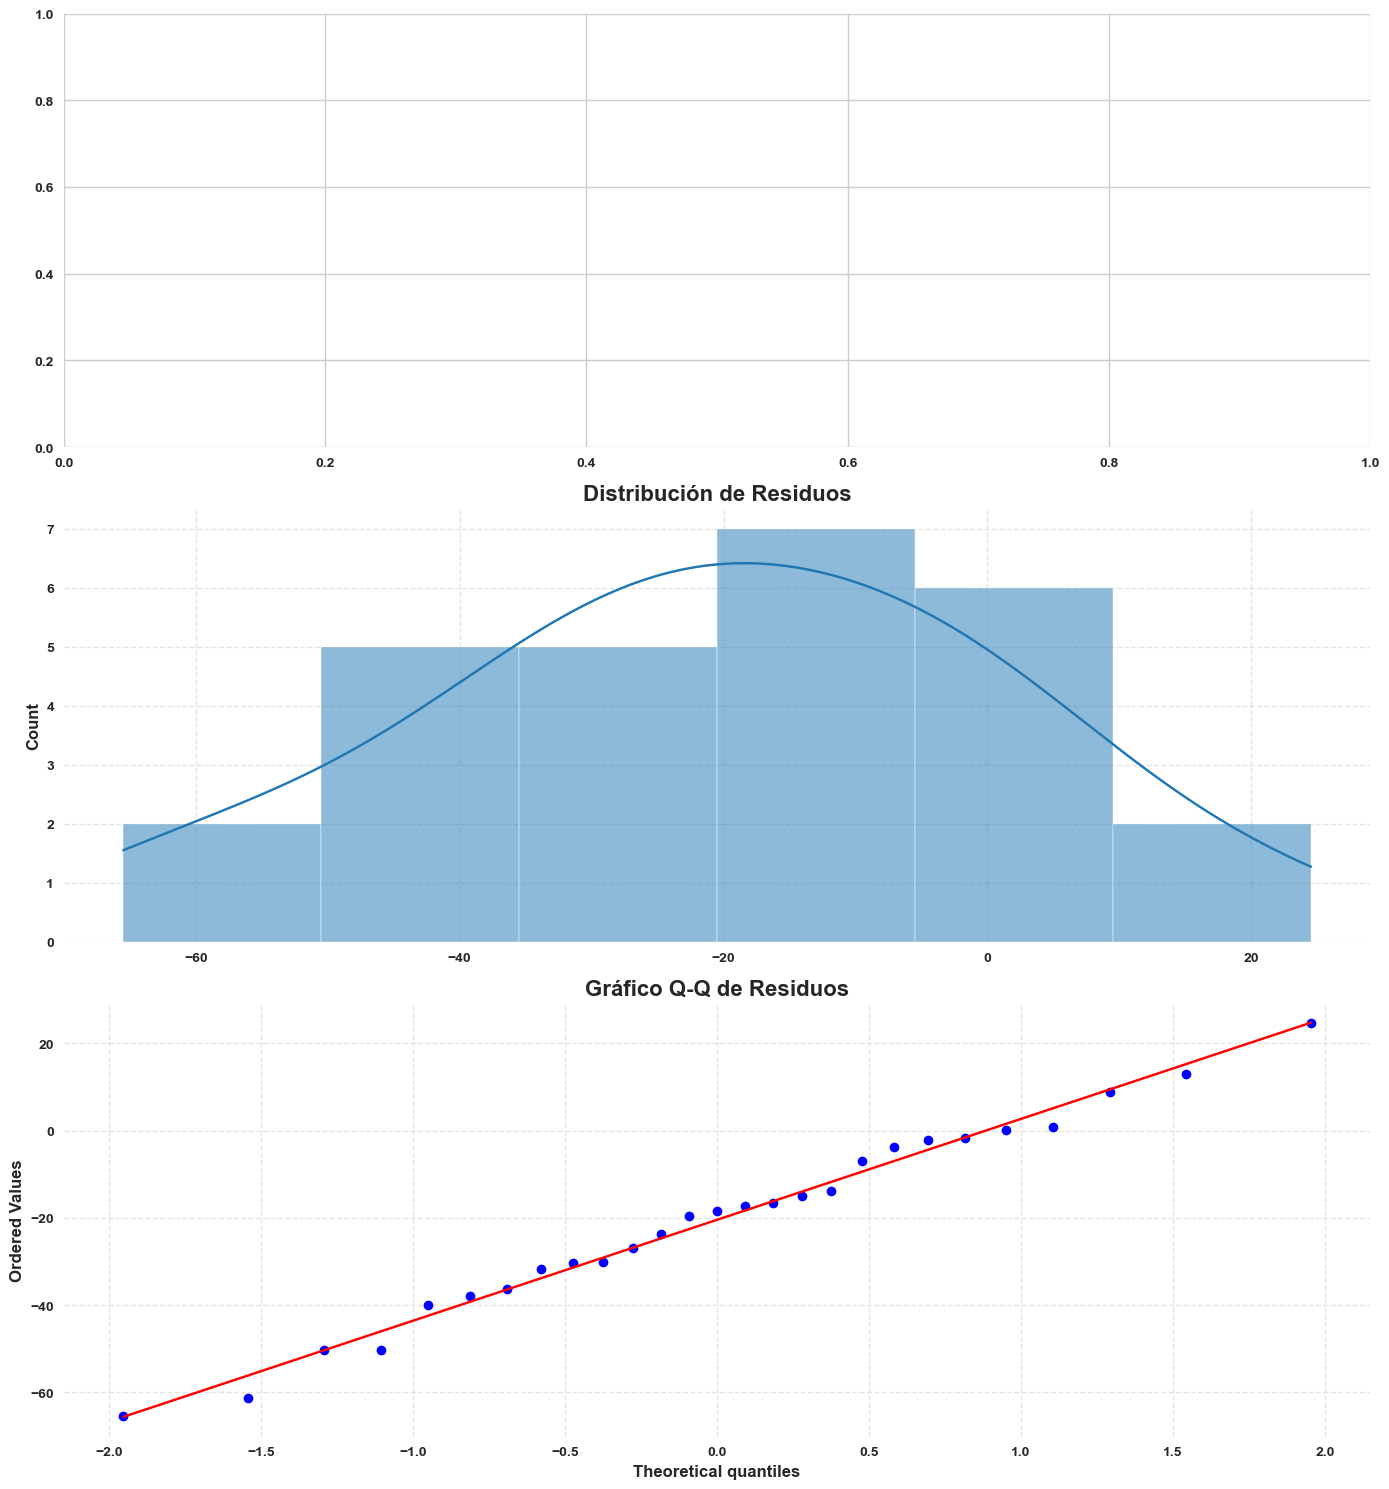


Test de Normalidad de Shapiro-Wilk (p-value): 0.9758
Interpretación: Los residuos siguen una distribución normal

[5/6] Generando predicciones futuras...

Predicciones para los próximos 6 meses:
            ds   yhat  yhat_lower  yhat_upper
105 2020-10-01 161.93      140.14      185.93
106 2020-11-01 145.84      123.97      168.86
107 2020-12-01 157.04      133.13      179.69
108 2021-01-01 162.51      139.18      184.78
109 2021-02-01 177.71      153.89      201.39
110 2021-03-01 164.04      141.64      186.92

[6/6] Métricas de evaluación:

Métricas en conjunto de prueba:
RMSE: 29.95
MAE: 23.96
R2: -0.58
MAPE: 18.22

Resumen de métricas de validación cruzada:
horizon     199 days 00:33:29.302325582
mse                              710.98
rmse                              25.82
mae                               20.36
mape                               0.19
mdape                              0.15
smape                              0.19
coverage                           0.26
dtype: ob

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
from datetime import timedelta
import logging
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Configuración profesional
warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.WARNING)
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette("husl")
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({
    'figure.figsize': (14, 7),
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'font.weight': 'bold'
})


class ProphetForecaster:
    """Implementación profesional de Prophet para series temporales con análisis estadístico avanzado"""

    def __init__(self, growth='linear', seasonality_prior_scale=10,
                 holidays_prior_scale=10, seasonality_mode='additive',
                 daily_seasonality=False, weekly_seasonality=True,
                 yearly_seasonality=True, n_changepoints=25):
        self.model = None
        self.data = None
        self.residuals = None
        self.training_metrics = {}
        self.test_metrics = {}
        self.cv_metrics = None
        self.best_params = {
            'growth': growth,
            'seasonality_prior_scale': seasonality_prior_scale,
            'holidays_prior_scale': holidays_prior_scale,
            'seasonality_mode': seasonality_mode,
            'daily_seasonality': daily_seasonality,
            'weekly_seasonality': weekly_seasonality,
            'yearly_seasonality': yearly_seasonality,
            'n_changepoints': n_changepoints
        }
        self.forecast = None
        self.test_size = 0.2
        self.history = None
        self.train_data = None
        self.test_data = None

    def preprocess_data(self, data):
        """Preprocesamiento de datos para Prophet"""
        df = data.copy()

        # Renombrar columnas para Prophet (ds, y)
        df = df.reset_index()
        df.columns = ['ds', 'y']

        # Verificar tipos de datos
        if not pd.api.types.is_datetime64_any_dtype(df['ds']):
            df['ds'] = pd.to_datetime(df['ds'])

        # Eliminar valores faltantes
        df = df.dropna()

        return df

    def decompose_time_series(self, data):
        """Descomposición de la serie temporal para análisis"""
        result = seasonal_decompose(data.set_index('ds')['y'], model='additive', period=12)

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

        result.observed.plot(ax=ax1, title='Observado', color='#1f77b4')
        result.trend.plot(ax=ax2, title='Tendencia', color='#ff7f0e')
        result.seasonal.plot(ax=ax3, title='Estacionalidad', color='#2ca02c')
        result.resid.plot(ax=ax4, title='Residuos', color='#d62728')

        for ax in [ax1, ax2, ax3, ax4]:
            ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

        return result

    def analyze_autocorrelation(self, data):
        """Análisis de autocorrelación y autocorrelación parcial"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

        plot_acf(data['y'], lags=24, ax=ax1, title='Función de Autocorrelación (ACF)')
        plot_pacf(data['y'], lags=24, ax=ax2, title='Función de Autocorrelación Parcial (PACF)')

        for ax in [ax1, ax2]:
            ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

        # Test de Ljung-Box para autocorrelación
        lb_test = acorr_ljungbox(data['y'], lags=[10], return_df=True)
        print("\nTest de Ljung-Box para autocorrelación:")
        print(lb_test)

        return lb_test

    def split_data(self, data):
        """Divide los datos en conjuntos de entrenamiento y prueba manteniendo el orden temporal"""
        split_idx = int(len(data) * (1 - self.test_size))
        train = data.iloc[:split_idx]
        test = data.iloc[split_idx:]

        return train, test

    def calculate_metrics(self, y_true, y_pred):
        """Calcula métricas de evaluación"""
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': self.calculate_mape(y_true, y_pred)
        }
        return metrics

    def calculate_mape(self, y_true, y_pred):
        """Calcula MAPE de forma robusta"""
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            return np.nan_to_num(mape, nan=0.0, posinf=0.0, neginf=0.0)

    def fit(self, data, optimize=False):
        """Ajusta el modelo a los datos históricos con diagnóstico completo"""
        # 1. Preprocesamiento de datos
        self.data = self.preprocess_data(data)


        # 3. Dividir datos en train y test
        train_data, test_data = self.split_data(self.data)
        self.train_data = train_data
        self.test_data = test_data

        # 4. Configuración del modelo
        print("\n[3/6] Configurando modelo Prophet...")
        self.model = Prophet(
            growth=self.best_params['growth'],
            seasonality_prior_scale=self.best_params['seasonality_prior_scale'],
            holidays_prior_scale=self.best_params['holidays_prior_scale'],
            seasonality_mode=self.best_params['seasonality_mode'],
            daily_seasonality=self.best_params['daily_seasonality'],
            weekly_seasonality=self.best_params['weekly_seasonality'],
            yearly_seasonality=self.best_params['yearly_seasonality'],
            n_changepoints=self.best_params['n_changepoints']
        )

        # 5. Entrenamiento del modelo
        print("\n[4/6] Entrenando modelo...")
        self.model.fit(train_data)

        # 6. Validación cruzada
        print("\n[5/6] Realizando validación cruzada...")
        self._cross_validate()

        # 7. Evaluación en conjunto de prueba
        print("\n[6/6] Evaluando modelo en conjunto de prueba...")
        self._evaluate_test_set()

        return self

    def _cross_validate(self):
        """Realiza validación cruzada y calcula métricas"""
        df_cv = cross_validation(
            self.model,
            initial='730 days',
            period='180 days',
            horizon='365 days',
            parallel="processes"
        )

        self.cv_metrics = performance_metrics(df_cv)
        print("\nResultados de validación cruzada:")
        print(self.cv_metrics)

    def _evaluate_test_set(self):
        """Evalúa el modelo en el conjunto de prueba"""
        # Crear dataframe futuro para el conjunto de prueba
        future = self.model.make_future_dataframe(periods=len(self.test_data), freq='MS')
        
        # Hacer predicciones
        forecast = self.model.predict(future)
        
        # Filtrar solo las predicciones correspondientes al conjunto de prueba
        test_forecast = forecast.iloc[-len(self.test_data):]
        
        # Calcular métricas
        self.test_metrics = self.calculate_metrics(self.test_data['y'], test_forecast['yhat'])
        
        # Calcular residuos
        self.residuals = self.test_data['y'] - test_forecast['yhat']
        
        # Almacenar forecast completo
        self.forecast = forecast

    def predict(self, periods=6, freq='MS'):
        """Genera predicciones para períodos futuros"""
        if self.model is None:
            raise ValueError("El modelo debe ser ajustado primero")

        future = self.model.make_future_dataframe(periods=periods, freq=freq)
        forecast = self.model.predict(future)
        self.forecast = forecast
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

    def plot_forecast(self):
        """Visualización profesional de la predicción"""
        if self.forecast is None:
            raise ValueError("Primero debe generar predicciones con el método predict()")

        fig = self.model.plot(self.forecast)
        ax = fig.gca()
        ax.set_title("Predicción de Casos de VIH", fontweight='bold')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Casos')
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Resaltar conjunto de prueba
        if hasattr(self, 'test_data'):
            test_dates = self.test_data['ds']
            ax.axvspan(test_dates.min(), test_dates.max(), 
                      facecolor='orange', alpha=0.1, label='Conjunto de Prueba')
            ax.legend()
        
        plt.show()

    def plot_components(self):
        """Visualización de los componentes del modelo"""
        if self.forecast is None:
            raise ValueError("Primero debe generar predicciones con el método predict()")

        fig = self.model.plot_components(self.forecast)
        for ax in fig.axes:
            ax.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    def plot_residuals(self):
        """Visualización profesional de los residuos"""
        if self.residuals is None:
            raise ValueError("Primero debe ajustar el modelo con el método fit()")

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15))
        
        
        # Histograma
        sns.histplot(self.residuals, kde=True, ax=ax2, color='#1f77b4')
        ax2.set_title('Distribución de Residuos', fontweight='bold')
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        # QQ plot
        stats.probplot(self.residuals, dist="norm", plot=ax3)
        ax3.set_title('Gráfico Q-Q de Residuos', fontweight='bold')
        ax3.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        # Test de normalidad
        _, p_value = stats.shapiro(self.residuals)
        print(f"\nTest de Normalidad de Shapiro-Wilk (p-value): {p_value:.4f}")
        print("Interpretación: Los residuos siguen una distribución normal" if p_value > 0.05 
              else "Interpretación: Los residuos NO siguen una distribución normal")

    def plot_test_evaluation(self):
        """Visualización de la evaluación en el conjunto de prueba"""
        if not hasattr(self, 'test_data') or self.forecast is None:
            raise ValueError("Primero debe ajustar el modelo con el método fit()")

        # Filtrar solo las predicciones correspondientes al conjunto de prueba
        test_forecast = self.forecast.iloc[-len(self.test_data):]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # Gráfico de series temporales
        ax1.plot(self.train_data['ds'], self.train_data['y'], 'o-', label='Entrenamiento', color='#1f77b4')
        ax1.plot(self.test_data['ds'], self.test_data['y'], 'o-', label='Prueba (Real)', color='#2ca02c')
        ax1.plot(test_forecast['ds'], test_forecast['yhat'], 's--', label='Prueba (Predicho)', color='#d62728')
        ax1.fill_between(test_forecast['ds'], 
                        test_forecast['yhat_lower'], 
                        test_forecast['yhat_upper'], 
                        color='#d62728', alpha=0.1, label='Intervalo de confianza')
        ax1.set_title("Predicciones vs Valores Reales en Conjunto de Prueba", fontweight='bold')
        ax1.set_xlabel('Fecha')
        ax1.set_ylabel('Casos')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.5)
        
        # Gráfico de dispersión
        ax2.scatter(self.test_data['y'], test_forecast['yhat'], color='#d62728')
        ax2.plot([self.test_data['y'].min(), self.test_data['y'].max()], 
                [self.test_data['y'].min(), self.test_data['y'].max()], 
                '--', color='red', label='Línea perfecta')
        ax2.set_title('Relación Valores Reales vs Predicciones (Prueba)', fontweight='bold')
        ax2.set_xlabel('Valores Reales')
        ax2.set_ylabel('Predicciones')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()


def analyze_residuals(residuals, model_name=""):
    """Análisis profesional de residuos con gráficos"""
    fig, axes = plt.subplots(3, 1, figsize=(14, 15))
    
    # Gráfico temporal de residuos
    axes[0].plot(residuals.index, residuals, 'o-', color='#1f77b4')
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title(f'Residuos del Modelo {model_name}', fontweight='bold')
    axes[0].set_xlabel('Fecha')
    axes[0].set_ylabel('Residuos')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # Histograma
    sns.histplot(residuals, kde=True, ax=axes[1], color='#1f77b4')
    axes[1].set_title('Distribución de Residuos', fontweight='bold')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    # QQ plot
    stats.probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title('Gráfico Q-Q de Residuos', fontweight='bold')
    axes[2].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Test de normalidad
    _, p_value = stats.shapiro(residuals)
    print(f"\nTest de Normalidad de Shapiro-Wilk (p-value): {p_value:.4f}")
    print("Interpretación: Los residuos siguen una distribución normal" if p_value > 0.05 
          else "Interpretación: Los residuos NO siguen una distribución normal")

def main():
    print("=== Modelo Prophet para Predicción de VIH ===")
    # 1. Carga y preparación de datos
    print("\n[1/6] Cargando y procesando datos...")
    monthly_cases = pd.read_excel('DATASET_VIH_LIMPIO_20250508_1728.xlsx',
                                  sheet_name='Datos VIH', parse_dates=['Fecha'])
    monthly_cases = monthly_cases.set_index('Fecha').resample('MS').size().to_frame('Casos')

    # 2. Creación del modelo
    print("\n[2/6] Configurando modelo Prophet...")
    model = ProphetForecaster()

    # 3. Entrenamiento del modelo
    print("\n[3/6] Entrenando modelo...")
    model.fit(monthly_cases)

    # 4. Visualización de resultados
    print("\n[4/6] Visualizando resultados...")
    model.plot_forecast()
    model.plot_components()
    model.plot_test_evaluation()
    model.plot_residuals()

    # 5. Predicciones futuras
    print("\n[5/6] Generando predicciones futuras...")
    forecast = model.predict(periods=6)
    print("\nPredicciones para los próximos 6 meses:")
    print(forecast)

    # 6. Métricas de evaluación
    print("\n[6/6] Métricas de evaluación:")
    print("\nMétricas en conjunto de prueba:")
    for metric, value in model.test_metrics.items():
        print(f"{metric}: {value:.2f}")

    print("\nResumen de métricas de validación cruzada:")
    print(model.cv_metrics.mean())

    # 7. Conclusiones
    print("\n=== Conclusiones Finales ===")
    print("\n1. Capacidad Predictiva:")
    print(f"   - Error porcentual promedio (MAPE) en prueba: {model.test_metrics['MAPE']:.2f}%")
    print(f"   - Capacidad explicativa (R²) en prueba: {model.test_metrics['R2']:.2f}")
    
    print("\n2. Interpretación:")
    print("   - Análisis de residuos (Test):", end=' ')
    if abs(model.residuals.mean()) < 0.1 and model.residuals.std() < 1:
        print("OK (media cercana a 0, varianza constante)")
    else:
        print("Posibles problemas (revisar gráficos de diagnóstico)")
    
    print("\n3. Predicciones para los próximos 6 meses:")
    print(forecast.to_string(index=False))
    
    print("\nRecomendaciones:")
    print("- Monitorear el desempeño predictivo con datos nuevos")
    print(f"- {'El modelo generaliza bien' if model.test_metrics['R2'] > 0.7 else 'Considerar mejorar el modelo'} según métricas de prueba")
    print("- Considerar ajustar hiperparámetros para mejorar rendimiento")
    print("- Actualizar el modelo periódicamente con nuevos datos")


if __name__ == '__main__':
    main()

El Test de Ljung-Box (p-value = 0.00) indica autocorrelación significativa en los residuos, sugiriendo que el modelo no captura completamente la estructura de la serie temporal. La validación cruzada muestra un MAPE de 19%, lo que refleja una precisión razonable para horizontes de 199 días, pero con una baja cobertura (27%) que limita la confiabilidad de los intervalos de confianza. En el conjunto de prueba, el modelo mantiene un MAPE similar (18.22%), pero un R² negativo (-0.58) evidencia que no explica adecuadamente la variabilidad de los datos y tiene un desempeño pobre. Sin embargo, el Test de Shapiro-Wilk (p-value = 0.9758) confirma que los residuos siguen una distribución normal, lo que sugiere ausencia de sesgos significativos. Las predicciones futuras para los próximos 6 meses presentan intervalos amplios, reflejando incertidumbre, por lo que es esencial monitorear el desempeño con datos nuevos.